In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed = 855835128

In [2]:
#file = pd.read_csv('AgeDataset-V1.csv' )
file = pd.read_csv('bow_clean_final.csv')

In [3]:
# file = pd.read_csv(r'E:\Auckland\2022 Semester 2\COMPSCI 760\Assignment\Presentation 2\ModelDf.csv',sep=',',usecols=[3,4,5,8])
#file = pd.read_csv('CleanDf.csv' )

In [4]:
file.nunique()

Id                   23394
Name                 23283
Short description    15240
Gender                   6
Country                746
Occupation             894
Birth year             124
Death year              48
Manner of death         68
Age of death            91
Words                23323
dtype: int64

In [5]:
file.reset_index(drop=True, inplace=True)
file

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death,Words
0,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952.0,2001.0,natural causes,49.0,douglas noel adam march may wa english author ...
1,Q368,Augusto Pinochet,"General, politician of Chile (1915-2006)",Male,Chile,Politician,1915.0,2006.0,natural causes,91.0,augusto jos ramn pinochet ugarte pinoe also u ...
2,Q407,Linda Lovelace,"American pornographic actress, later anti-porn...",Female,United States of America,Artist,1949.0,2002.0,accident,53.0,linda lovelace born linda susan boreman januar...
3,Q409,Bob Marley,"Jamaican singer, songwriter and musician",Male,Jamaica,Artist,1945.0,1981.0,natural causes,36.0,robert nesta marley om february may baptised b...
4,Q410,Carl Sagan,"American astrophysicist, cosmologist, author a...",Male,United States of America,Researcher,1934.0,1996.0,natural causes,62.0,carl edward sagan sen saygn november december ...
...,...,...,...,...,...,...,...,...,...,...,...
23390,Q70706427,Hevrin Khalaf,Syrian Kurdish politician and civil engineer,Female,Syria,Politician,1984.0,2019.0,homicide,35.0,hevrin khalaf kurdish hevrn xelef arabic also ...
23391,Q70794825,Richard Tracey,Australian judge,Male,Australia,Judge,1948.0,2019.0,natural causes,71.0,richard ross sinclair tracey rfd qc august oct...
23392,Q71262658,Patrick Day,American boxer,Male,United States of America,Athlete,1992.0,2019.0,accident,27.0,patrick day august october wa american profess...
23393,Q74642113,Baha Abu al-Ata,Palestinian terrorist organization leader,Male,State of Palestine,Condottiero; resistance fighter,1977.0,2019.0,death in battle,42.0,baha abu alata arabic november november wa lea...


## Gender

In [6]:
file['Gender'].value_counts()

Male                          19069
Female                         4304
Transgender Female               13
Transgender Male                  7
Transgender Female; Female        1
Intersex                          1
Name: Gender, dtype: int64

In [7]:
gender_combine = {'Transgender Female' : 'Diverse', 
                  'Transgender Male': 'Diverse', 
                  'Eunuch; Male' : 'Diverse', 
                  'Transgender Female; Female':'Diverse',
                  'Eunuch':'Diverse', 
                  'Intersex': 'Diverse', 
                 }
file['Gender'] = file['Gender'].replace(gender_combine)
file['Gender'].value_counts()

Male       19069
Female      4304
Diverse       22
Name: Gender, dtype: int64

## Manner of death

In [8]:
file['Manner of death'].value_counts()

natural causes                                 18596
accident                                        1785
suicide                                         1479
homicide                                        1280
capital punishment                               123
                                               ...  
falling                                            1
gunshot                                            1
transition                                         1
patricide                                          1
homicide; Atentado para uno suizo Zollinger        1
Name: Manner of death, Length: 68, dtype: int64

(-0.5, 799.5, 499.5, -0.5)

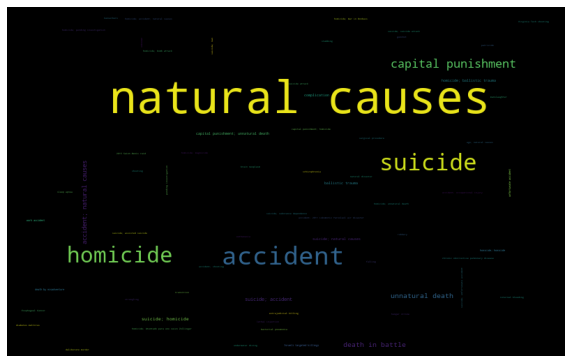

In [9]:
from wordcloud import WordCloud 

MoD = file['Manner of death'].value_counts().to_dict()
freq_death = WordCloud(width =800, height =500, min_font_size=2).generate_from_frequencies(MoD)
plt.figure(figsize=(10,10))
plt.imshow(freq_death)
plt.axis('off')

Making natural causes, accident, suicide, homicide and capital punishment our target label.

In [10]:
file['Manner of death']=file['Manner of death'].astype(str)
file['Manner of death']=file['Manner of death'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Manner of death'].value_counts()

natural causes                           18596
accident                                  1801
suicide                                   1498
homicide                                  1292
capital punishment                         127
unnatural death                             18
death in battle                             17
complication                                 3
ballistic trauma                             3
unfortunate accident                         2
death by misadventure                        2
work accident                                2
Israeli targeted killings                    2
euthanasia                                   1
diabetes mellitus                            1
2015 Saint-Denis raid                        1
internal bleeding                            1
suicide attack                               1
lethal injection                             1
sleep apnea                                  1
pending investigation                        1
Canserbero   

Feature engineering

In [11]:
MoD_combine = {'unnatural death ' : 'accident', 
                'death in battle': 'homicide', 
                'complication' : 'natural causes ', 
                'ballistic trauma':'homicide',
                'work accident':'accident', 
                'Israeli targeted killings': 'homicide',
                'unfortunate accident': 'accident',
               'death by misadventure': 'accident', 
               'brain neoplasm': 'natural causes', 
               'underwater diving': 'accident', 
               'natural disaster': 'accident', 
               'stabbing': 'homicide', 
               'extrajudicial killing': 'homicide', 
               'chronic obstructive pulmonary disease': 'natural causes', 
               'sleep apnea': 'natural causes', 
               'schizophrenia': 'natural causes', 
               'bacterial pneumonia': 'natural causes', 
               'falling': 'accident', 
               'suicide attack': 'suicide',
               'manslaughter': 'homicide', 
               'lethal injection': 'capital punishment', 
               'Canserbero': 'natural causes', 
               'Esophageal Cancer': 'natural causes', 
               'diabetes mellitus': 'natural causes', 
               '2015 Saint-Denis raid': 'homicide',
               'natural causes ': 'natural causes', 
               'unnatural death': 'accident', 
               'shooting': 'homicide', 
               'deliberate murder': 'homicide',
               'gunshot': 'homicide', 
               'Virginia Tech shooting': 'homicide',
               'strangling': 'homicide', 
               'hunger strike': 'accident', 
               'robbery': 'homicide',
               'euthanasia': 'natural causes',
               'internal bleeding': 'accident', 
                 }
file['Manner of death'] = file['Manner of death'].replace(MoD_combine)
file['Manner of death'].value_counts()

natural causes           18605
accident                  1830
suicide                   1499
homicide                  1324
capital punishment         128
natural causes               3
transition                   1
surgical procedure           1
unknown                      1
age                          1
patricide                    1
pending investigation        1
Name: Manner of death, dtype: int64

In [12]:
#only getting the top 5 deaths
deaths = ['natural causes' ,'suicide', 'homicide', 'accident', 'capital punishment']
file = file[file['Manner of death'].isin(deaths)]

<AxesSubplot:title={'center':'Percentage of manner of deaths'}, ylabel='Count'>

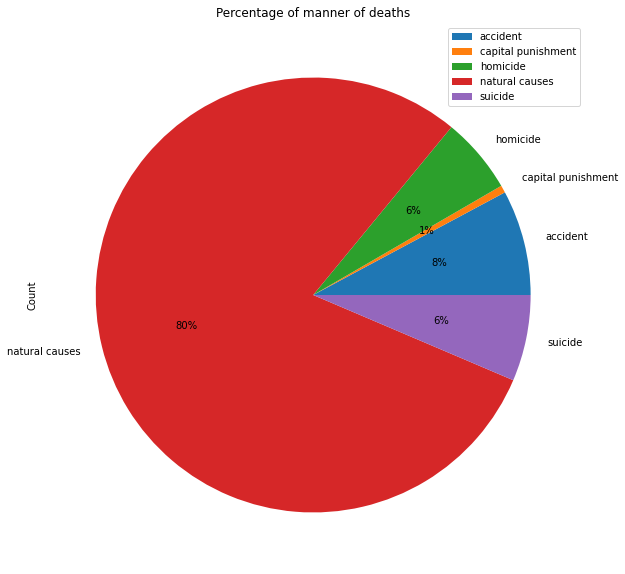

In [13]:
#pie chart for manner of death
#class imbalance
Manner_of_death = file[['Manner of death']].groupby(['Manner of death']).size().reset_index(name='Count').sort_values('Count', ascending = False)
Manner_of_death.groupby(['Manner of death']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%',title='Percentage of manner of deaths', figsize=(15, 10))

<AxesSubplot:xlabel='Age of death', ylabel='Manner of death'>

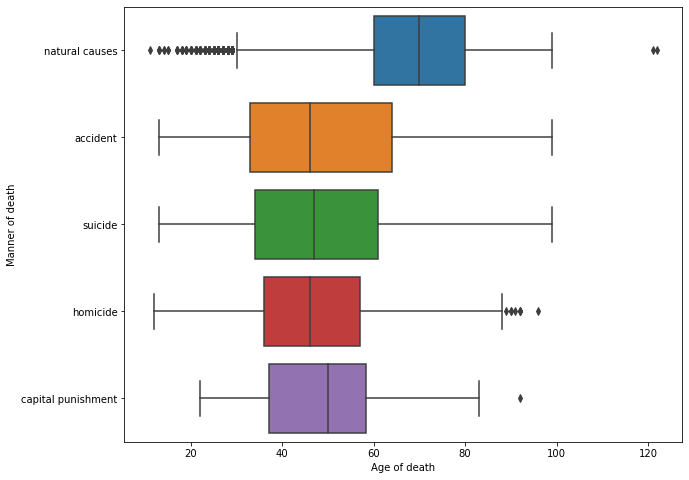

In [14]:
plt.figure(figsize=(10,8))
sns.boxplot(data=file, x='Age of death', y = 'Manner of death')

<AxesSubplot:xlabel='Gender', ylabel='Birth year'>

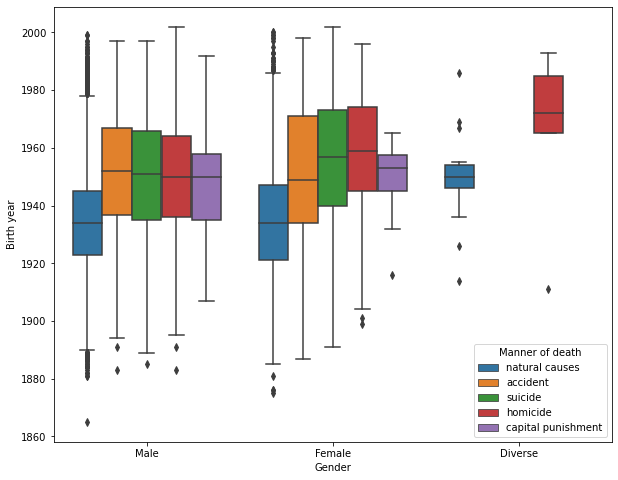

In [15]:
plt.figure(figsize=(10,8))
sns.boxplot(data=file[file['Birth year']>1700], x='Gender', y = 'Birth year',hue='Manner of death')

## Occupation

In [16]:
file = file.assign(Occupation=lambda d: d['Occupation'].astype(str))
file['Occupation']=file['Occupation'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
occu = file['Occupation'].value_counts()
top_occupation = occu.head(10)
top_occupation

Artist                10556
Athlete                3871
Politician             2879
Researcher             1071
Journalist              548
Military personnel      436
Businessperson          409
Religious figure        200
Teacher                 175
Engineer                135
Name: Occupation, dtype: int64

## Country

In [17]:
file = file.assign(Country=lambda d: d['Country'].astype(str))
file['Country']=file['Country'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Country'].value_counts()

United States of America          10655
United Kingdom                     2232
Canada                              909
France                              772
Australia                           588
                                  ...  
Federated States of Micronesia        1
Gambia                                1
Comoros                               1
People's Republic of Hungary          1
Ethiopia                              1
Name: Country, Length: 232, dtype: int64

In [18]:
# pd.crosstab(file['Manner of death'],file['Occupation'],normalize='index').plot.bar(stacked=True)

<AxesSubplot:xlabel='Manner of death'>

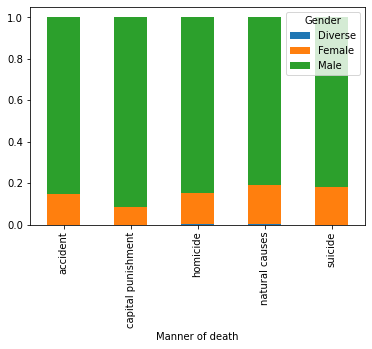

In [19]:
pd.crosstab(file['Manner of death'],file['Gender'],normalize='index').plot.bar(stacked=True)

In [20]:
file.reset_index(drop=True, inplace=True)

## Hyper parameter tuning

In [21]:
file

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death,Words
0,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952.0,2001.0,natural causes,49.0,douglas noel adam march may wa english author ...
1,Q368,Augusto Pinochet,"General, politician of Chile (1915-2006)",Male,Chile,Politician,1915.0,2006.0,natural causes,91.0,augusto jos ramn pinochet ugarte pinoe also u ...
2,Q407,Linda Lovelace,"American pornographic actress, later anti-porn...",Female,United States of America,Artist,1949.0,2002.0,accident,53.0,linda lovelace born linda susan boreman januar...
3,Q409,Bob Marley,"Jamaican singer, songwriter and musician",Male,Jamaica,Artist,1945.0,1981.0,natural causes,36.0,robert nesta marley om february may baptised b...
4,Q410,Carl Sagan,"American astrophysicist, cosmologist, author a...",Male,United States of America,Researcher,1934.0,1996.0,natural causes,62.0,carl edward sagan sen saygn november december ...
...,...,...,...,...,...,...,...,...,...,...,...
23381,Q70706427,Hevrin Khalaf,Syrian Kurdish politician and civil engineer,Female,Syria,Politician,1984.0,2019.0,homicide,35.0,hevrin khalaf kurdish hevrn xelef arabic also ...
23382,Q70794825,Richard Tracey,Australian judge,Male,Australia,Judge,1948.0,2019.0,natural causes,71.0,richard ross sinclair tracey rfd qc august oct...
23383,Q71262658,Patrick Day,American boxer,Male,United States of America,Athlete,1992.0,2019.0,accident,27.0,patrick day august october wa american profess...
23384,Q74642113,Baha Abu al-Ata,Palestinian terrorist organization leader,Male,State of Palestine,Condottiero,1977.0,2019.0,homicide,42.0,baha abu alata arabic november november wa lea...


In [22]:
#combining all words into single column for bag of words
file = file.assign(Birth_year=lambda d: d['Birth year'].astype(str))
file['Country'].replace(' ', '-', regex=True,inplace=True)
# file['Combined_words'] = file['Gender'] + ' ' + file['Country'] + ' ' + file['Occupation'] + ' ' + file['Birth_year'] + ' ' + file['preprocessed_Short description']
file['Combined_words'] = file['Gender'] + ' ' + file['Country'] + ' ' + file['Occupation'] + ' ' + file['Birth_year'] + ' ' + file['Words']

In [23]:
target = file['Manner of death'] #decreased the labels to 5 
#data = file[['Gender','Occupation','Country','Birth year']]

In [24]:
target.nunique()

5

In [25]:
file.isnull().sum()

Id                   0
Name                 0
Short description    0
Gender               0
Country              0
Occupation           0
Birth year           0
Death year           0
Manner of death      0
Age of death         0
Words                0
Birth_year           0
Combined_words       0
dtype: int64

In [26]:
# pre-processing data

# data_T = data.T
# arr1 = data_T.to_numpy()
# temp = np.zeros((4,len(data)))
# le1 = preprocessing.LabelEncoder()
# for i in range(len(arr1)):
#     le1.fit(arr1[i])
#     temp[i] = le1.transform(arr1[i])
# x_T = pd.DataFrame(temp)
# x = x_T.T
# x = x.to_numpy()

arr2 = target.to_numpy()
le2 = preprocessing.LabelEncoder()
le2.fit(arr2)
y = le2.transform(arr2)
# The result of pre-processing
#print("The feature vectors:\n",x)
print("The predictive vector:\n",y)

The predictive vector:
 [3 3 0 ... 0 2 3]


In [27]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))
x = vectorizer.fit_transform(file['Combined_words'])
#x = x_1.toarray()

In [28]:
x.shape

(23386, 427447)

In [29]:
import imblearn # pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [30]:
#stratified Kfold for imbalance class
skf = StratifiedKFold(n_splits = 5, random_state = seed, shuffle = True) # 5 number of folds
skf.get_n_splits(x,y)

for train, test in skf.split(x, y): #for hyper parameter tuning
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = seed)

In [31]:
x_test.shape

(18605, 427447)

In [32]:
x_train.shape

(74420, 427447)

Entropy is better than Gini in this data set.

There is no need to modify the min_samples_split parameter.

# Gridsearch

In [33]:
%%time
# Entropy,max_depth = 3, min_samples_leaf = 1, min_samples_split = 2
param_grid = {
    'max_depth':np.arange(1,20),
    'min_samples_leaf':np.arange(1,10),
    'min_samples_split':np.arange(2,10)
}
DTC = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
GS = GridSearchCV(DTC,param_grid,cv=skf) #stratified cross fold of 5
GS.fit(x_train,y_train)
print(GS.best_params_)
print(GS.best_score_)

KeyboardInterrupt: 

In [35]:
%%time

#DT = DecisionTreeClassifier(criterion = 'entropy', max_depth = 13, min_samples_leaf = 10, min_samples_split = 7)
DT = DecisionTreeClassifier()
#stratified CV 
score = []
for train, test in skf.split(x, y):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    DTClass = DT.fit(x_train,y_train)
    
    test_score = DTClass.score(x_test, y_test)
    score.append(test_score)

print(f'Mean accuracy {(sum(score)/len(score))*100}%')
# train_score = DTClass.score(x_train, y_train)
# print('Accuracy on train set: {:.3f}%'.format(train_score * 100))

# test_score = DTClass.score(x_test, y_test)
# print('Accuracy on test set: {:.3f}%'.format(test_score * 100))

Mean accuracy 92.23649556570814%
CPU times: user 12min 35s, sys: 452 ms, total: 12min 35s
Wall time: 12min 35s


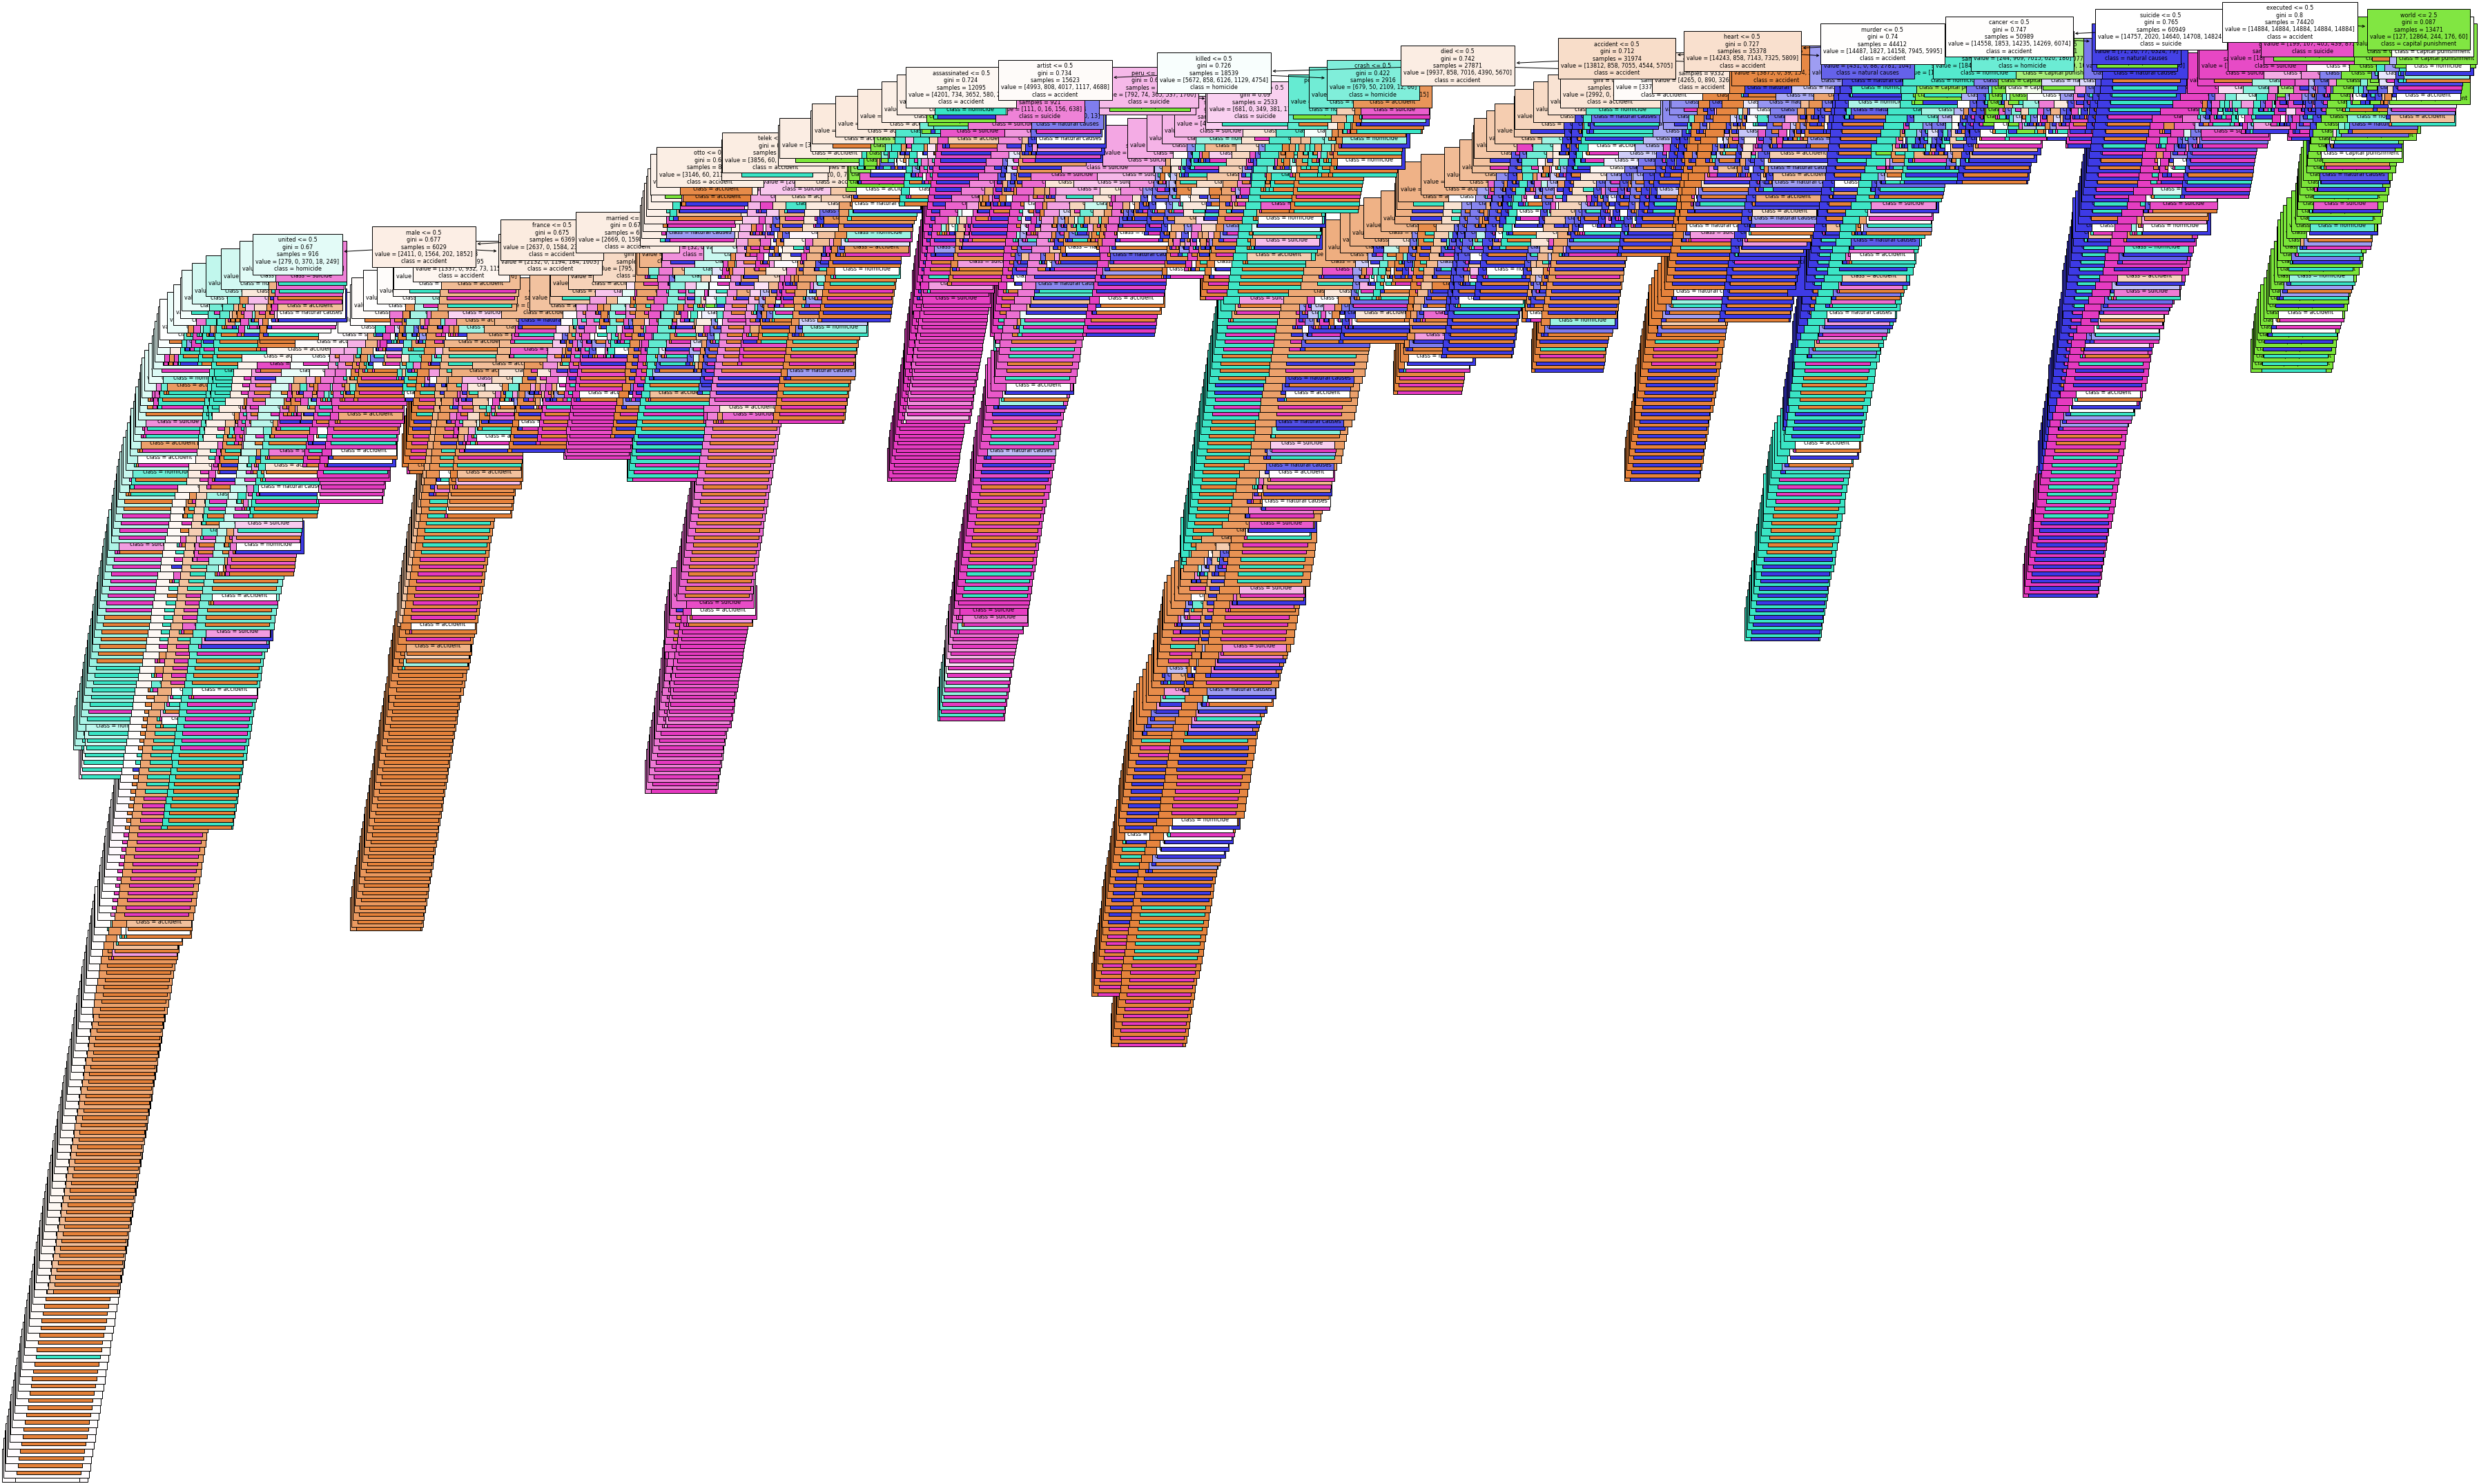

In [36]:
class_label = ['accident', 'capital punishment' ,'homicide' , 'natural causes','suicide']
plt.figure(figsize=(50,30))
tree.plot_tree(DTClass, fontsize=8,feature_names=vectorizer.get_feature_names_out(), class_names=class_label , filled=True)
plt.tight_layout(h_pad=2, w_pad=3)

In [38]:
#getting features picked by decision tree
decision_feature_importatnt = pd.DataFrame(
                                    data=DTClass.feature_importances_,
                                    columns=['importance'],
                                    index= vectorizer.get_feature_names_out(),
                                    ).sort_values(by=['importance'], ascending=False)

In [39]:
dcfeature = decision_feature_importatnt[decision_feature_importatnt['importance'] > 0] #disregarding not used features

In [40]:
dcfeature

,importance
executed,1.987700e-01
suicide,1.077862e-01
cancer,8.388152e-02
murder,6.543555e-02
heart,3.375689e-02
...,...
tpnek,7.362012e-09
kat,5.367163e-09
idilbi,4.750766e-09
red,4.640283e-09


(-0.5, 799.5, 499.5, -0.5)

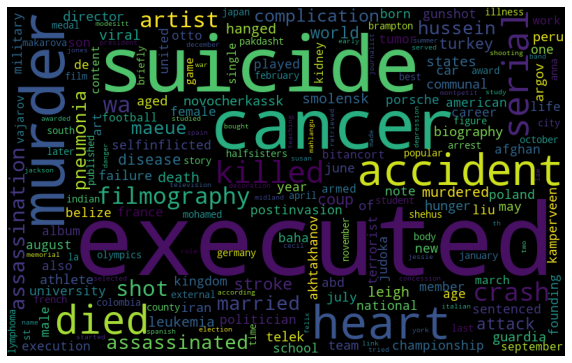

In [41]:
freq_death = WordCloud(width =800, height =500, min_font_size=2).generate_from_frequencies(dcfeature['importance'].to_dict())
plt.figure(figsize=(10,10))
plt.imshow(freq_death)
plt.axis('off')

# RANDOM FOREST FOR COMPARISON

In [42]:
%%time
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state=seed)

score_rf= []
for train, test in skf.split(x, y):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    random_forest.fit(x_train,y_train)
    
    test_score = random_forest.score(x_test, y_test)
    score_rf.append(test_score)
print(f'Mean accuracy {(sum(score_rf)/len(score_rf))*100}%')

KeyboardInterrupt: 

In [43]:
#getting features picked by RF
decision_feature_importatnt = pd.DataFrame(
                                    data=random_forest.feature_importances_,
                                    columns=['importance'],
                                    index= vectorizer.get_feature_names_out(),
                                    ).sort_values(by=['importance'], ascending=False)
dcfeature = decision_feature_importatnt[decision_feature_importatnt['importance'] > 0] #disregarding not used features

freq_death = WordCloud(width =800, height =500, min_font_size=2).generate_from_frequencies(dcfeature['importance'].to_dict())
plt.figure(figsize=(10,10))
plt.imshow(freq_death)
plt.axis('off')

ValueError: We need at least 1 word to plot a word cloud, got 0.